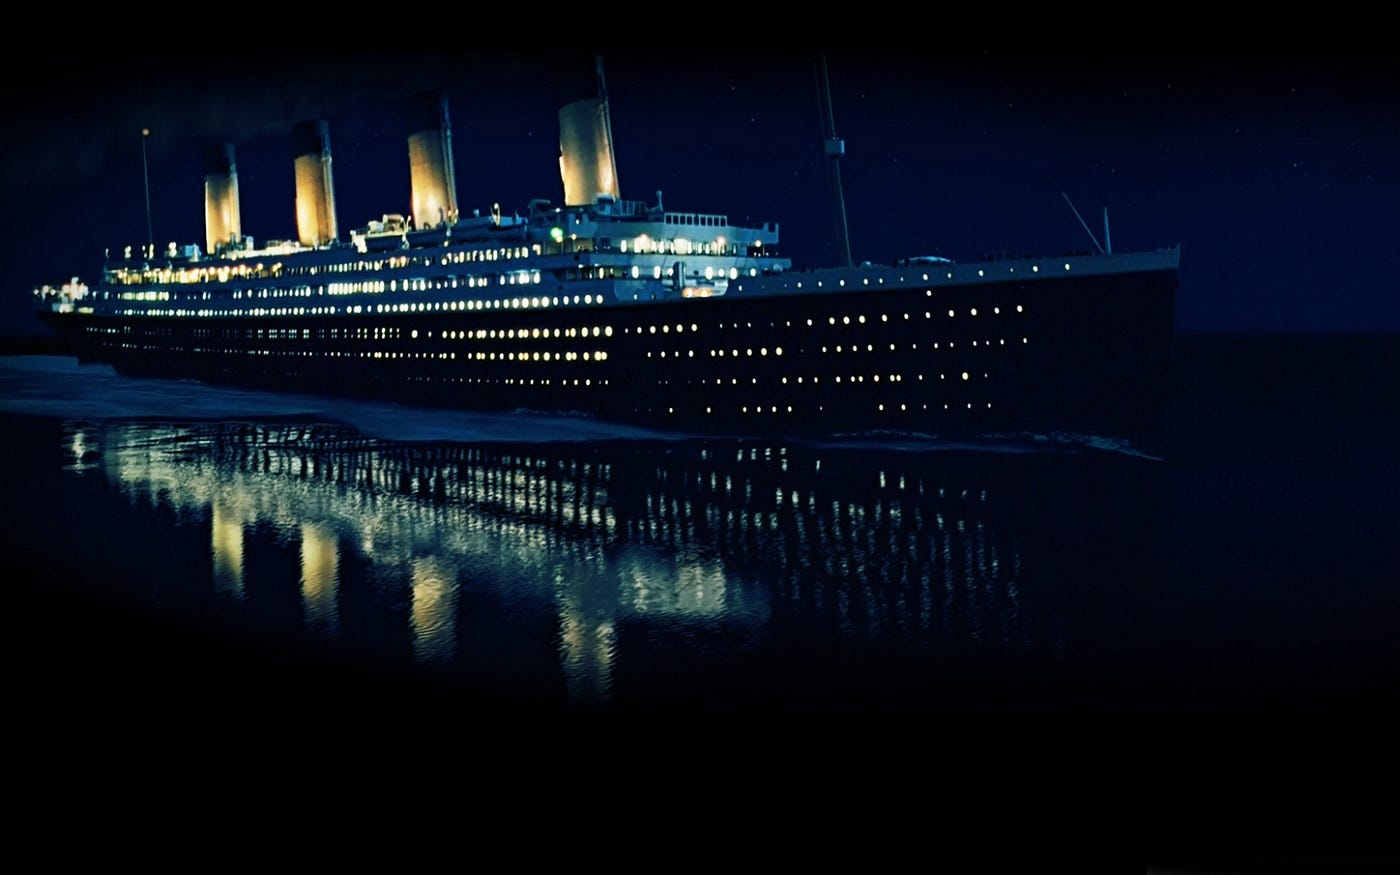

The sinking of the Titanic is one of the most infamous maritime disasters in history. However, from a data science perspective, it presents an interesting opportunity to develop a machine learning model that can predict which passengers survived the tragedy. In this project, we will be using PySpark, a powerful data processing framework, to build a predictive model using the Titanic training dataset. Our goal is to create a robust and accurate model that can accurately predict passenger survival based on various features such as age, gender, ticket class, and more. By doing so, we hope to gain a deeper understanding of the factors that played a role in passenger survival during the Titanic disaster.

<a class="anchor" id="0.1"></a>
[](http://)

# **Table of Contents**

1.	[Initialize pyspark framework and load data into pyspark's dataframe](#1)
2.	[Overview of Dataset](#2)
3.	[Detect missing values and abnormal zeroes](#3)
4.	[Explolatory Data analysis in Pyspark](#4)
5.	[Features Selection: 1st phase](#5)    
6.	[Features Selection: 2nd phase ](#6)
7.	[pipeline to fit the train set](#7)
8.	[Classification](#8)


# **1. Initialize pyspark framework and load data into pyspark's dataframe** <a class="anchor" id="1"></a>

[Go back to table of contents](#0.1)


In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=fa7b4a264bcf3346ecb30b6b3b3a49253a56d1f29a3c4bd741ce20bebc6c2a43
  Stored in directory: /root/.cache/pip/wheels/5a/54/9b/a89cac960efb57c4c35d41cc7c9f7b80daa21108bc376339b7
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import isnan, when, col,count,lit, regexp_extract, mean, avg, split
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import pyspark

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (13,6)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# Create Spark Session
from pyspark.sql import SparkSession

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/23 09:15:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# File location and type
file_location = "/kaggle/input/titanic/train.csv"
# df = spark.read.csv(file_location, header=True, inferSchema=True)
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [5]:
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **2. Overview of Dataset** <a class="anchor" id="2"></a>

[Go back to table of contents](#0.1)

### Schema, columns & datatypes of the data set:
   *The data set has both single value columns (int, string) and columns made of arrays/list.*

In [6]:
df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [7]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

Columns overview


,Column Name,Data type
0,PassengerId,int
1,Survived,int
2,Pclass,int
3,Name,string
4,Sex,string
5,Age,double
6,SibSp,int
7,Parch,int
8,Ticket,string
9,Fare,double


#### **Comments** regarding the **`Age` feature:**<br>
- The **age range varies from less than 0.5 years to 80 years**.  
- The **average age of the passengers is just below 30 years** and the **median age is slightly below the average**.
- One can **infer that there are 177 missing values**, as we'll **confirm when we check the missing values regarding all features**.
  <br><br>

In [8]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

Data frame describe (string and numeric columns only):


,summary,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,count,891,891,891,891,891,714,891,891,891,891,204,889
1,mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
2,stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
3,min,1,0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
4,max,891,1,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


In [9]:
print(f'There are total {df.count()} row, Let print first 3 data rows:')
df.limit(3).toPandas()

There are total 891 row, Let print first 3 data rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


# **3. Detect missing values and abnormal zeroes** <a class="anchor" id="3"></a>

[Go back to table of contents](#0.1)

After having a first sight of the columns, the first thing we should check is if the data set having any missing value.
- For string columns, we check for `None` and `null`
- For numeric columns, we check for zeroes and `NaN`
- For array type columns, we check if the array contain zeroes or `NaN`

In [10]:
from pyspark.sql.functions import isnan, count, when, col
display(df.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in df.columns]))

DataFrame[PassengerId: bigint, Survived: bigint, Pclass: bigint, Name: bigint, Sex: bigint, Age: bigint, SibSp: bigint, Parch: bigint, Ticket: bigint, Fare: bigint, Cabin: bigint, Embarked: bigint]

# **4. Explolatory Data analysis** <a class="anchor" id="4"></a>

[Go back to table of contents](#0.1)

#### **How many survived?**

In [11]:
df.groupBy("Survived").count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



#### **Comment:** 
- Regarding **our dataset more than 60% (≈ 61.6%) of the passengers didn't survive.**<br> (this **statistic can also be inferred from the descriptive statistics displayed above**).<br>
- - -

### How the **survival rate was correlated with some variables/features:**<br>
#### - **`Sex`:**

In [12]:
df.groupBy("Sex","Survived").count().show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|  male|       0|  468|
|female|       1|  233|
|female|       0|   81|
|  male|       1|  109|
+------+--------+-----+



#### **Comments:**
- Almost **65% of the travelers** of our dataset **were male** while the remaining **35% were female**. 
- What **stands out the most** is the **comparative percentage** of **women and men that survived**: almost **`75%` of the women survived** while **not even `20%` (≈18.9%) of the male passengers succeeded in surviving!**<br><br>

#### - **`Pclass`:**

In [13]:
df.groupBy("Pclass","Survived").count().show()

+------+--------+-----+
|Pclass|Survived|count|
+------+--------+-----+
|     1|       0|   80|
|     3|       1|  119|
|     1|       1|  136|
|     2|       1|   87|
|     2|       0|   97|
|     3|       0|  372|
+------+--------+-----+



#### **Comments:**
- The **class3 had the highest number of travelers**, followed by class1 and the class with least passengers was the class2. The **number of travelers in class3** (the **least fortunate...**) **was more than the number of passengers in the class1 and class2 combined!**
- The **actual survival rate of a class1 traveler** was the **highest** one (**≈63%**). **Class2** and **class3 travelers** had an **actual survival rate of respectively 47.3% and 24,2%**. 
  <br><br>

#### - **`Age`:**

In [14]:
df_pd = df.toPandas()

[Text(0.5, 0, 'Age Groups'), Text(0, 0.5, 'Number  of  Travelers')]

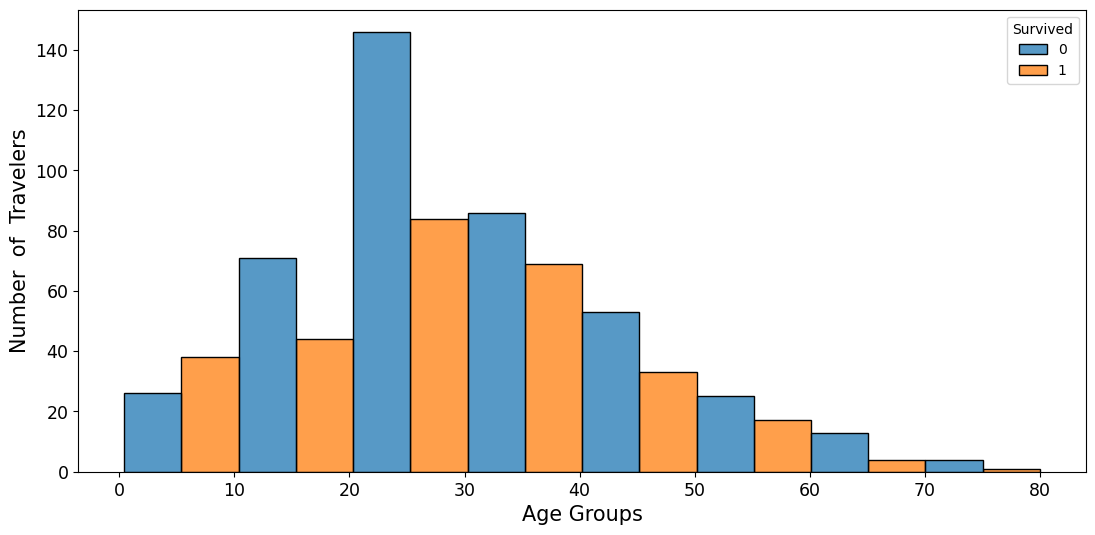

In [15]:
df_pd = df.toPandas()
plt.rcParams["axes.labelsize"] = 15
plt.tick_params(labelsize=12.5)
ax = sns.histplot(data=df_pd, x="Age", hue="Survived",  multiple="dodge", bins=8)
ax.set(xlabel='Age Groups',
       ylabel='Number  of  Travelers')

#### **Comments:**
- The **only age group with a survival rate higher than 50% is the youngest one**.
- **Senior people** (older than 60 years old) **had a very low survival rate**.
- **Contrary to what could be expected** (in our perception...) **teenagers travelers and people in their twenties had a lower survival rate than people in their fourties and in their fifties**.
  <br><br>

In [16]:
df.select('Age').distinct().count() #THIS IS THE NUMBER OF UNIQUE VALUES IN THE AGE COLUMN

89

#### - **`Embarked`:**<br>

In [17]:
df.groupBy("Embarked","Survived").count().show()

+--------+--------+-----+
|Embarked|Survived|count|
+--------+--------+-----+
|    null|       1|    2|
|       Q|       1|   30|
|       S|       0|  427|
|       S|       1|  217|
|       C|       1|   93|
|       Q|       0|   47|
|       C|       0|   75|
+--------+--------+-----+



#### **Comments:**
- Embarked implies the **Port of Embarkation**: **C** = Cherbourg; **Q** = Queenstown; **S** = Southampton.
- The **majority of the travelers**, around **72% boarded from Southampton**. Approximatelly **19% boarded from Cherbourg** and the **remaining travelers boarded from Queenstown (almost 9%)**. 
- **Only the passengers who boarded from Cherbourg had an actual chance of survival greater than 50%**. Travellers who **boarded from Southampton** had **the actual least chance of survival (≈33%)**.<br><br>

#### - **`Fare`:**<br>

In [18]:
df.groupBy("Fare","Survived").count().show(5)

+-------+--------+-----+
|   Fare|Survived|count|
+-------+--------+-----+
|   28.5|       0|    1|
|56.4958|       1|    5|
|  24.15|       0|    7|
|  120.0|       1|    4|
|  15.85|       0|    2|
+-------+--------+-----+
only showing top 5 rows



In [19]:
df_pd.Fare.describe() #THIS IS THE STATISTICAL DESCRIPTION OF THE FARE COLUMN

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

#### Splitting the fare feature into 4 categories according to the quartiles:

In [20]:
df_pd['Fare_Class'] = pd.cut(df_pd['Fare'], bins=[0,7.91,14.45,31,512.33], labels=['Low','Mid_Low-Mid','Mid-Mid_High','High'])

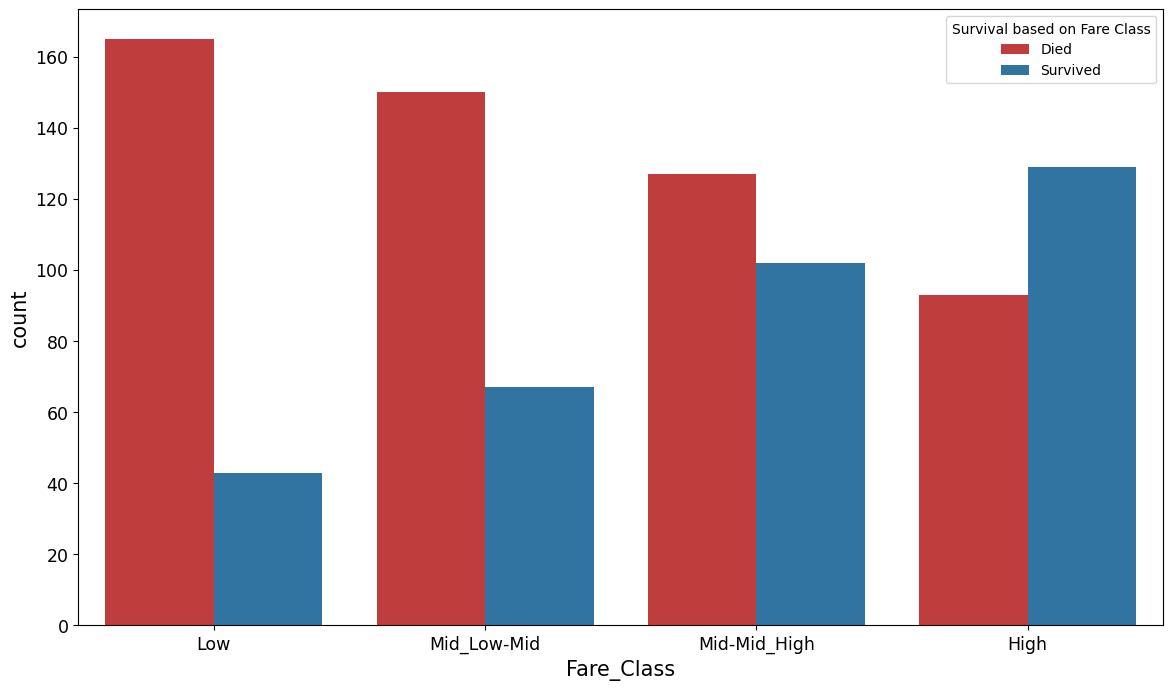

In [21]:
plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams["axes.labelsize"] = 15
plt.tick_params(labelsize=12.5)
ax_2 = sns.countplot(x = "Fare_Class", hue = "Survived", data = df_pd, palette=["C3", "C0"]).legend(labels = ["Died", "Survived"])
ax_2.set_title("Survival based on Fare Class")


#### **Comment:**<br>
- **Tendentially, the higher the fare the higher the survival rate**.<br><br>

#### - **`Ticket`:**<br>

In [22]:
df.groupBy("Ticket","Survived").count().show(5)

+--------+--------+-----+
|  Ticket|Survived|count|
+--------+--------+-----+
|  330958|       1|    1|
|  350404|       0|    1|
|    2693|       0|    1|
|  349912|       0|    1|
|CA. 2343|       0|    7|
+--------+--------+-----+
only showing top 5 rows



In [23]:
df.select('Ticket').distinct().count() #this is the number of unique values in the Ticket column

681

#### **Comment:**<br>
- The tickets' number **does not translate into any valuable meaning to explain the chances of survival of a given passanger**. It was **something to be expected** after looking at the **descriptive statistics associated with this feature**.<br><br>


#### - **`Cabin`:**<br>

In [24]:
df.groupBy("Cabin", "Survived").count().show(5)

+-----+--------+-----+
|Cabin|Survived|count|
+-----+--------+-----+
|  C78|       0|    1|
|   F2|       0|    1|
|   A7|       0|    1|
|  D45|       1|    1|
|  C47|       1|    1|
+-----+--------+-----+
only showing top 5 rows



In [25]:
df.select('Cabin').distinct().count() #this is the number of unique values in the Cabin column

148

#### **Comments:**
- What **we said about the feature tickets it is valid for the feature cabin: it does not translate into any valuable meaning to explain the chances of survival of a given passanger.**
- Besides, as we will see below, **the number of missing values regarding this variable it is very high, both in absolute (687) and relative terms (around 77%)**<br><br>

# **5. Features Selection: 1st phase** <a class="anchor" id="5"></a>

[Go back to table of contents](#0.1)

 - **Removing unnecessary features before handling missing data regarding age and embarked features.**<br>

In [26]:
df_pyspark=df.drop('Cabin','Ticket','PassengerId')

In [27]:
df_pyspark.show(5)

+--------+------+--------------------+------+----+-----+-----+-------+--------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+--------------------+------+----+-----+-----+-------+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|
+--------+------+--------------------+------+----+-----+-----+-------+--------+
only showing top 5 rows



#### **Comment:** 
- The **feature 'name' wasn't removed** because it will be **crucial for filling in the missing values regarding the feature age**.<br><br>
- - -

#### **`Imputing Missing Values`:**

#### - **`AGE`:**<br>
- To **replace the missing values, we could assign them the mean or median age of the dataset**. If we **used the distinct() and count() functions**, like we did above for other features, we would see that there were **many different ages**, **just by looking** at the **descriptive statistics** regarding the **age feature** one can tell that it **would not be appropriate to impute either the mean or median age to the missing values**.<br><br>
- **Assumptions**: **age is an important factor when it comes to survival rate**, for instance, the **youngest age group had higher chances of survival than senior people**. <br>The **available lifeboats, by regulation, are primarily used to save chlidren and women.**<br><br>
- We can use a **regex filter to extract the Title** and run this for every row of the dataframe and consequently **find the passangers who are women and children** (we'll **refine** this procedure latter on because **all unmarried females** across all ages had the 'Miss' title. However, among those females there were **young girls** and **adult females** with, most likely, **relevant different mean ages**), and **also adult males** with different **socio-professional categories**.<br><br>
  - **After extracting the title** we'll see that the **average age** can **vary significantly for the distinct titles**.<br><br>
    - We **won't just extract titles and assign the average age to the missing values**, we will be **more accurate** than that in **imputing missing ages** as **you will see later on**.<br><br>

In [28]:
from pyspark.sql.functions import mean,col,split, regexp_extract, lit
 #extract the title from the name column
df_pyspark = df_pyspark.withColumn("Title",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))

In [29]:
df_pyspark.show(5)

+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked|Title|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|   Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|  Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S| Miss|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|  Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|   Mr|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
only showing top 5 rows



#### **Let's see the different `titles` in our dataset:**<br>

In [30]:
df_pyspark.select("Title").distinct().show()

+--------+
|   Title|
+--------+
|     Don|
|    Miss|
|Countess|
|     Col|
|     Rev|
|    Lady|
|  Master|
|     Mme|
|    Capt|
|      Mr|
|      Dr|
|     Mrs|
|     Sir|
|Jonkheer|
|    Mlle|
|   Major|
|      Ms|
+--------+



#### **Comments:**
- **There are titles that can be grouped into the same "categories"** like, for instance, **'Capt'** and **'Major' both are Officers**.
- Besides, there are titles that are either **misspelled** or that **although different and correctly spelled  mean the very same thing** like, for instance, **'Mlle' means 'Miss', 'Mme' means 'Mrs'** and **Ms" means "Miss"**.
- Regarding 'Dr' and 'Rev' we chose to replace them by 'Other'.<br><br>

#### Let's **replace the titles according to our rationale:**

In [31]:
df_pyspark = df_pyspark.replace(['Capt','Col', 'Major', 'Jonkheer','Don','Sir','Dr','Rev','Countess','Mme','Mlle','Ms','Lady'],
               ['Officer','Officer','Officer','Royalty','Royalty', 'Royalty', 'Other','Other', 'Royalty', "Mrs", "Miss", 'Miss', "Royalty"])

In [32]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|
|       0|     3|    Moran, Mr. James|  male|null|    0|    0| 8.4583|       Q|    Mr|
|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|51.8625|       S|    Mr|
|       0|     3|Palsson, Master. ...|  male| 2.0|    3|    1| 21.075|       S|Master|
|       1|     3|Johnson, Mrs. Osc...|femal

#### **Comments**: 
- **All unmarried females across all ages had the 'Miss' title**. However, among those females there were **young girls** and **adult females** with, most likely, **relevant different mean ages**.
- There is a **rationale** that we **may apply to  distinguish those two cases**: **if Parch > 0**, then most likely **they are female children traveling with at least one parent** (we will name the title as **'MissPar'**); **if Parch = 0**, then it's likely that they are adult females traveling alone (we will name the title as **'MissA'**). <br><br>

**Let us check how different are the mean ages for those two different cases:**<br>

In [33]:
print("Average age of a Miss travelling without Parents 'MissA'", df_pyspark[(df_pyspark.Title=="Miss") & (df_pyspark.Parch==0)].agg(mean('Age').alias('mean')).collect())
print("Average age of a Miss travelling with Parents 'MissPar'", df_pyspark[(df_pyspark.Title=="Miss") & (df_pyspark.Parch!=0)].agg(mean('Age').alias('mean')).collect())

Average age of a Miss travelling without Parents 'MissA' [Row(mean=27.68617021276596)]
Average age of a Miss travelling with Parents 'MissPar' [Row(mean=11.863636363636363)]


#### **Comment: the difference between the mean ages for the two different cases is noticeable!** <br>Being so, let's **add a column with the new titles for each of those cases replacing the 'Miss' title** by **'MissA'** and **'MissPar' accordingly**:<br>

In [34]:
# Average age of a Miss travelling without Parents 'MissA' [Row(mean=21.773972602739725)]
df_pyspark = df_pyspark.withColumn("NewTitle",
                        when((df_pyspark.Title=="Miss") & (df_pyspark.Parch==0), 'MissA')
                       .when((df_pyspark.Title=="Miss") & (df_pyspark.Parch!=0), 'MissPar')
                       .otherwise(df_pyspark['Title']))
                      
    

In [35]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|NewTitle|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|      Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|     Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|   MissA|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|     Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|      Mr|
|       0|     3|    Moran, Mr. James|  male|null|    0|    0| 8.4583|       Q|    Mr|      Mr|
|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|51.8625|       S|    Mr|      Mr|
|       0|     3|Palsson, Master. ...|  

> - To be **more accurate** in **imputing missing ages** we will **compute the mean age of groups of `similar passengers`** considering some **`FEATURES COMBINED`**.<br><br>
> - For that, given the **huge difference regarding the actual survival rate among the three different classes** (Pclass1, Pclass2 and Pclass3), we'll **group the features `NewTitle` and `Pclass` to define groups of `similar passengers`** (in what concerns to those two features) and then **find** the **`average age`** of those **`similar passengers`**:

In [36]:
my_list = df_pyspark.groupby(['NewTitle', 'Pclass']).avg(('Age')).collect()

In [37]:
spark.createDataFrame(my_list).show()

+--------+------+------------------+
|NewTitle|Pclass|          avg(Age)|
+--------+------+------------------+
|   MissA|     2|            30.375|
|     Mrs|     3|33.515151515151516|
|      Mr|     1| 41.58045977011494|
|   Other|     1|             43.75|
| MissPar|     3| 6.903846153846154|
| MissPar|     1|              21.0|
|   MissA|     1| 34.25806451612903|
|     Mrs|     1|              40.4|
|   Other|     2|              42.0|
|      Mr|     2| 32.76829268292683|
|  Master|     3| 5.350833333333334|
|   MissA|     3|21.697674418604652|
| Officer|     1|              56.6|
|      Mr|     3|28.724890829694324|
| Royalty|     1|              41.6|
|  Master|     2|2.2588888888888885|
|  Master|     1| 5.306666666666667|
| MissPar|     2|10.538461538461538|
|     Mrs|     2| 33.68292682926829|
+--------+------+------------------+



#### Let's **add a column** ('**AgeImputed**') and **replace the 'age' missing values assigning them the average age of the `similar passengers`**:<br>

In [38]:
# Here we are imputing the missing values of the Age column with the average age of the passengers with the same title and class.

df_pyspark = df_pyspark.withColumn("AgeImputed",
                         when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 28.72)
                        .when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 32.77)
                        .when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 41.58)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 33.5)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 33.68)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 40.4)
                        .when((df_pyspark.NewTitle=="Other") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 42)
                        .when((df_pyspark.NewTitle=="Other") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 43.8)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 21.7)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 30.38)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 34.26)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 6.9)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 10.54)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 21)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 5.35)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 2.26)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 5.31)
                        .when((df_pyspark.NewTitle=="Officer|") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 56.6)
                        .when((df_pyspark.NewTitle=="Royalty|") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 41.6)
                        .otherwise(df_pyspark.Age))

#### - **`EMBARKED`**:<br>
- This feature has **only two missining values** and **almost 3/4 of the passengers boarded from "S"** (Southampton). **We'll impute "S"**.

In [39]:
df_pyspark = df_pyspark.na.fill({"Embarked" : 'S'})

In [40]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+----------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|NewTitle|AgeImputed|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+----------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|      Mr|      22.0|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|     Mrs|      38.0|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|   MissA|      26.0|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|     Mrs|      35.0|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|      Mr|      35.0|
|       0|     3|    Moran, Mr. James|  male|null|    0|    0| 8.4583|       Q|    Mr|      Mr|     28.72|
|       0|     1|McCarthy, Mr. Tim...

# **6. Features Selection: 2nd phase** <a class="anchor" id="6"></a>

[Go back to table of contents](#0.1)

 - **Removing unnecessary features after the `FEATURE ENGINEERING`:**<br>

In [41]:
df_pyspark=df_pyspark.drop('Name','Age','Title')

#### Let's **check** if **there are still any missing values**:<br>

In [42]:
df_pyspark.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in df_pyspark.columns]).show()

+--------+------+---+-----+-----+----+--------+--------+----------+
|Survived|Pclass|Sex|SibSp|Parch|Fare|Embarked|NewTitle|AgeImputed|
+--------+------+---+-----+-----+----+--------+--------+----------+
|       0|     0|  0|    0|    0|   0|       0|       0|         0|
+--------+------+---+-----+-----+----+--------+--------+----------+



#### **Check the schema after the changes we made**:

In [43]:
df_pyspark.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- NewTitle: string (nullable = true)
 |-- AgeImputed: double (nullable = true)



### - **Let's do some MORE feature engineering:**<br>
- - -
- **Create a function to convert categorical attributes into a binary vector with at most a single one-value per row that indicates the input category index** (using **OneHotEncoder**), the last category is not included by default), **but first convert non-numeric data to numeric data** (using **StringIndexer**):<br>

In [44]:
stages=[]
cat=['Sex','Embarked','Pclass','NewTitle']

In [45]:
for catCol in cat:
    indexer = StringIndexer(inputCol=catCol, outputCol=catCol+'Index',stringOrderType='frequencyDesc')
    encoder=OneHotEncoder(inputCols=[indexer.getOutputCol()],outputCols=[catCol+'catVec'])
    stages+=[indexer,encoder]
    
stages

[StringIndexer_9147e4e045ed,
 OneHotEncoder_70767adb999e,
 StringIndexer_33b14a644c85,
 OneHotEncoder_8ef17d4bffcc,
 StringIndexer_2c22bc1553da,
 OneHotEncoder_791cfe8994cd,
 StringIndexer_2f6544f33f3d,
 OneHotEncoder_ffcd07a2b892]

- Let's **combine the list of columns of our interest into a single vector column properly named 'features'** (using **VectorAssembler**):<br>

In [46]:
numeric=['Fare','SibSp','Parch','AgeImputed']

In [47]:
assembleInputs=[c+'catVec' for c in cat]+numeric
assembler=VectorAssembler(inputCols=assembleInputs,outputCol="features")
stages+=[assembler]


# **7. pipeline to fit the train set** <a class="anchor" id="7"></a>

[Go back to table of contents](#0.1)
#### **Now** let's do the **train-test split**:<br>

In [48]:
train_data, test_data = df_pyspark.randomSplit([0.8,0.2],seed=42) 

In [49]:
# pipeline
pipeline=Pipeline().setStages(stages)
pipelineModel=pipeline.fit(train_data)

#### **Transform the train and test sets**<br>

In [50]:
train_pipe=pipelineModel.transform(train_data)
test_pipe=pipelineModel.transform(test_data)

In [51]:
train_pipe.head(1)

[Row(Survived=0, Pclass=1, Sex='female', SibSp=0, Parch=0, Fare=28.7125, Embarked='C', NewTitle='MissA', AgeImputed=50.0, SexIndex=1.0, SexcatVec=SparseVector(1, {}), EmbarkedIndex=1.0, EmbarkedcatVec=SparseVector(2, {1: 1.0}), PclassIndex=1.0, PclasscatVec=SparseVector(2, {1: 1.0}), NewTitleIndex=1.0, NewTitlecatVec=SparseVector(7, {1: 1.0}), features=SparseVector(16, {2: 1.0, 4: 1.0, 6: 1.0, 12: 28.7125, 15: 50.0}))]

# **8. Classification** <a class="anchor" id="8"></a>

[Go back to table of contents](#0.1)


### - **Baseline model and evaluation:**<br><br>

In [52]:
from pyspark.ml.classification import RandomForestClassifier

In [53]:
# Random Forest Classification
rf = RandomForestClassifier(labelCol = 'Survived', predictionCol='prediction', seed=42)
rfmodel = rf.fit(train_pipe)

In [54]:
pred_results_rf = rfmodel.transform(test_pipe)

In [55]:
 # For the Training Set
summary=rfmodel.summary
summary.accuracy

0.839142091152815

In [56]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Survived')

rfevaluator=evaluator.evaluate(pred_results_rf)
# equal to:
auroc = evaluator.evaluate(pred_results_rf, {evaluator.metricName: "areaUnderROC"})

aupr= evaluator.evaluate(pred_results_rf, {evaluator.metricName: "areaUnderPR"})
print('Area under ROC curve: ',auroc)
print('Area under PR curve: ',aupr)

Area under ROC curve:  0.8982240437158471
Area under PR curve:  0.891833388917776


### - **Hyperparameter tuning with CrossValidator and evaluation:**<br><br>

In [57]:
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 4, 5])
               .addGrid(rf.numTrees, [5, 10, 20, 100])
             .build())

In [58]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluatorRF=BinaryClassificationEvaluator(labelCol='Survived')

cv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluatorRF,
                      numFolds = 5)

rfcv=cv.fit(train_pipe)

In [59]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
predictions=rfcv.bestModel.transform(test_pipe)
evaluatorRF.evaluate(predictions)

0.8963700234192037

In [60]:
# As, by default, the metric name of the BinaryClassificationEvaluator is areaUnderROC the first value will be equal to the cell above
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr= evaluatorRF.evaluate(predictions, {evaluatorRF.metricName: "areaUnderPR"})
print('Area under ROC curve: ',auroc)
print('Area under PR curve: ',aupr)

Area under ROC curve:  0.8963700234192037
Area under PR curve:  0.8920463126057557


#### - We **can get the accuracy and F1 score using MulticlassClassificationEvaluator** which **can be used for binary classification** as well. Let's use it for **accuracy:**

In [61]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [62]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
rf_accuracy = multi_evaluator.evaluate(predictions)
print("Accuracy of RandomForestClassifier is = ", (rf_accuracy))

Accuracy of RandomForestClassifier is =  0.8413793103448276


#### - **Model Evaluation with SciKit-Learn: Classification Report**

In [63]:
from sklearn.metrics import classification_report

In [64]:
y_true = predictions.select(['Survived']).collect()
y_pred = predictions.select(['prediction']).collect()

In [65]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        84
           1       0.85      0.75      0.80        61

    accuracy                           0.84       145
   macro avg       0.84      0.83      0.83       145
weighted avg       0.84      0.84      0.84       145



## **Conclusions**:<br>
- - - 
-  **After completing the tasks** it's  fair to say that we managed to **meet the goal we set ourselves** given the **scores we achieved for the metrics commonly used for this dataset with Pyspark**.
- The **scores we achieved for the metrics were higher using hyperparameter tuning with CrossValidator than the ones we reached with the baseline model**, as expected.
- The model **can be improved** a little, namely in what concerns to **missing age values imputation** and by **using more classifiers**.